# D. Go to the Wider World

## 더 넓은 세상(=오목판)으로!

Ch.19, App.B에서 학습한 model들은 전부 fully CNN으로 되어
있습니다.
이 때문에 각 위치별로 가중치를 주기 힘들다는 단점도 있지만,
각 위치에 대한 action은 그 근방의 정보로만 결정한다는
locality, 위치 정보를 온존한다는 점에서 나름 장점도 있다고
생각합니다.

그런데 어차피 fully CNN이라면, 학습하는 판 크기와, 실제 게임하는
판 크기가 별로 안 중요한 것 아닌가요?

그래서 여기서는 기존 $15 \times 15$ 크기 대신에
판 크기를 $19 \times 19$나 그 이상으로 늘려서
과연 agent가 어떻게 플레이하는지 확인해봅니다.

아래와 같이 학습 모듈은 제외하고, 실행에 필요한 모듈을
모두 준비합니다.

### Environment

In [1]:
!rm -rf mock5.py mock5 gen.cpp read_record.py gen
!git clone https://github.com/lumiknit/mock5.py
!mv mock5.py/mock5 .
!mv mock5.py/gen2_record/gen.cpp .
!mv mock5.py/gen2_record/read_record.py .
!g++ -O2 -fopenmp -o gen gen.cpp

Cloning into 'mock5.py'...
remote: Enumerating objects: 152, done.
remote: Counting objects: 100% (152/152), done.
remote: Compressing objects: 100% (101/101), done.
remote: Total 152 (delta 74), reused 121 (delta 47), pack-reused 0
Receiving objects: 100% (152/152), 40.18 KiB | 8.04 MiB/s, done.
Resolving deltas: 100% (74/74), done.


In [2]:
from mock5 import Mock5
from mock5.analysis import Analysis as M5Analysis
import mock5.analysis as m5analysis
import mock5.agent_random as m5rand
import mock5.agent_analysis_based as m5aa
import mock5.agent_ad as m5ad
import mock5.agent_pt as m5pt
import mock5.agent_df as m5df

import matplotlib.pyplot as plt

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim

import os
import time

device = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: {}".format(device))

torch.backends.cudnn.benchmark = True
torch.autograd.set_detect_anomaly(False)

print("cudnn: {} (det {}; bench {})".format(
    torch.backends.cudnn.enabled,
    torch.backends.cudnn.deterministic,
    torch.backends.cudnn.benchmark))
print("OpenMP: {}".format(torch.backends.openmp.is_available()))

Device: cuda
cudnn: True (det False; bench True)
OpenMP: True


### Agent & Policy Transformer

In [3]:
def fn_name(fn):
  if hasattr(fn, 'name'): return fn.name
  else: return repr(fn)
  
def agent(pi, epsilon=0):
  # pi must return array of non-negative values
  def c(game):
    w, h = game.width, game.height
    m, p = np.ones(h * w), np.array(pi(game))
    for i in range(h * w):
      if game.board[i] != 0: m[i], p[i] = 0, 0
    s = p.sum()
    if np.random.uniform() < epsilon or s == 0:
      s = m.sum()
      if s == 0: return None, None # Cannot do anything
      else: idx = np.random.choice(h * w, p=(m / s))
    else: idx = np.random.choice(h * w, p=(p / s))
    return idx // w, idx % w
  c.name = 'stochastic({})'.format(fn_name(pi))
  return c

def agent_mixed(game):
  a = np.random.uniform()
  if a < 0.4: return m5aa.agent(game)
  elif a < 0.8: return m5ad.agent(game)
  elif a < 0.9: return m5pt.agent(game)
  else: return m5df.agent(game)
agent_mixed.name = 'agent-mixed-analysis-based'

`test_agents`에 판 크기를 입력받도록
변경합니다.

In [8]:
def test_agents(H, W, num_game, agent1, agent2, p_msg=True):
  w1, w2 = 0, 0
  c1, c2 = 0, 0
  for i in range(num_game):
    g = Mock5(H, W)
    if i % 2 == 0:
      result = g.play(agent1, agent2, random_first=False,
        print_intermediate_state=False, print_messages=False)
    else:
      result = g.play(agent2, agent1, random_first=False,
        print_intermediate_state=False, print_messages=False)
      if result != 0: result = 3 - result
    if result == 1:
      w1 += 1
      c1 += len(g.history)
    elif result == 2:
      w2 += 1
      c2 += len(g.history)
  if p_msg:
    print("-- Test Result --")
    print("* Agent1 = {} \n* Agent2 = {}".format(
        fn_name(agent1), fn_name(agent2)))
    print("Total : {:5d}".format(num_game))
    print("A1 Win: {:5d} ({:5.3f}) (avg.mov {:6.1f})".format(w1, w1 / num_game, c1 / max(1, w1)))
    print("A2 Win: {:5d} ({:5.3f}) (avg.mov {:6.1f})".format(w2, w2 / num_game, c2 / max(1, w2)))
  return (w1 + (num_game - w1 - w2) * 0.5) / num_game

### Neural Network


In [5]:
class Flatten(nn.Module):
  def forward(self, x):
    if len(x.shape) == 3: return x.view(-1)
    else: return x.flatten(1, -1)

class Block1(nn.Module):
  def __init__(self, ch, int_ch, ker):
    super().__init__()
    self.seq = nn.Sequential(
      nn.Conv2d(ch, int_ch, ker, padding='same'),
      nn.GELU(),
      nn.Conv2d(int_ch, ch, ker, padding='same'))
  def forward(self, x):
    y_0 = self.seq(x)
    return nn.functional.gelu(x + y_0)

class Policy(nn.Module):
  def __init__(self):
    super().__init__()
    self.seq = nn.Sequential(
      nn.Conv2d(2, 128, 3, padding='same'),
      nn.GELU(),
      Block1(128, 128, 3),
      Block1(128, 128, 3),
      Block1(128, 128, 3),
      nn.Conv2d(128, 1, 5, padding='same'),
      nn.GELU(),
      # Flatten
      Flatten(),
      # Softmax
      nn.LogSoftmax(dim=-1))

  def forward(self, x):
    return self.seq(x)

def game_to_tensor(game):
  t = torch.zeros(2, game.height * game.width, dtype=torch.float)
  for i in range(game.height * game.width):
    b = game.board[i]
    if b == game.player: t[0][i] = 1.0
    elif b != 0: t[1][i] = 1.0
  return t.view(2, game.height, game.width)

def policy_model(net):
  def c(game):
    X = game_to_tensor(game).to(device)
    with torch.no_grad():
      p = torch.exp(net(X))
    arr = p.squeeze().to('cpu').numpy()
    return arr
  c.name = 'model({:x})'.format(id(net))
  return c

def agent_policy(net):
  return agent(policy_model(net))

In [6]:
NUM_SLOTS_HOF = 5
WEIGHT_FILE = 'app_b_last.weight'
WEIGHT_FILE_IDX = lambda idx: "app_b_{:08x}.weight".format(idx)

def load_hof_file(filename):
  global hof, pns
  hof = torch.load(WEIGHT_FILE)
  pns = [None] * NUM_SLOTS_HOF
  for i in range(NUM_SLOTS_HOF):
    pns[i] = Policy().to(device)
    pns[i].load_state_dict(hof['slots'][i]['dict'])
    print("  ([{}] al score {})".format(i, hof['slots'][i]['al_score']))

def load_last_hof(): load_hof_file(WEIGHT_FILE)
def load_hof(index): load_hof_file(WEIGHT_FILE_IDX(index))

def init_curr():
  global curr, curr_pn
  curr_pn = Policy().to(device)
  curr = {
    'dict': None,
    'gen': hof['gen'],
    'al_score': 0 }
  idx = np.random.randint(NUM_SLOTS_HOF)
  curr_pn.load_state_dict(hof['slots'][idx]['dict'])

## Policy Transformer


In [7]:
def rescore(game, a, idx):
  m = max([a.get_critical_at(game.player, dir, idx) for dir in range(4)])
  o = max([a.get_critical_at(3 - game.player, dir, idx) for dir in range(4)])
  ad = 0
  if m >= o:
    ad = 1
    o = m
  if o >= m5analysis.N_5: return ad + 4
  elif o >= m5analysis.N_OPEN_4: return ad + 2
  else: return 1

def pt_regulate(policy):
  def p(game):
    p = policy(game)
    a = M5Analysis(game)
    score = np.zeros(game.height * game.width)
    for i in range(game.height * game.width):
      if game.board[i] == 0: score[i] = rescore(game, a, i)
    mmax = score.max()
    mask = (score >= mmax).astype(float)
    masked = p * mask
    if masked.sum() <= 0: return mask
    else: return masked
  p.name = 'pt_regulate({})'.format(policy.name)
  return p

def agent_model(net):
  return agent(pt_regulate(policy_model(net)))

### Algorithm과 대국

In [9]:
load_last_hof()
init_curr()

  ([0] al score 4.4399999999999995)
  ([1] al score 4.3933333333333335)
  ([2] al score 4.52)
  ([3] al score 4.533333333333333)
  ([4] al score 4.4799999999999995)


먼저 $15 \times 15$에서는 다음과 같은 결과가 나옵니다.

In [12]:
a = [m5aa, m5ad, m5pt, m5df]
for i in range(len(a)):
    test_agents(15, 15, 20, agent_model(curr_pn), a[i].agent)

-- Test Result --
* Agent1 = stochastic(pt_regulate(model(7ff60118aa10))) 
* Agent2 = agent-analysis-based
Total :    20
A1 Win:    19 (0.950) (avg.mov   21.1)
A2 Win:     1 (0.050) (avg.mov   21.0)
-- Test Result --
* Agent1 = stochastic(pt_regulate(model(7ff60118aa10))) 
* Agent2 = agent-analysis-defensive
Total :    20
A1 Win:    20 (1.000) (avg.mov   22.8)
A2 Win:     0 (0.000) (avg.mov    0.0)
-- Test Result --
* Agent1 = stochastic(pt_regulate(model(7ff60118aa10))) 
* Agent2 = agent-pt
Total :    20
A1 Win:    19 (0.950) (avg.mov   26.1)
A2 Win:     1 (0.050) (avg.mov   38.0)
-- Test Result --
* Agent1 = stochastic(pt_regulate(model(7ff60118aa10))) 
* Agent2 = agent-df
Total :    20
A1 Win:    18 (0.900) (avg.mov   25.7)
A2 Win:     2 (0.100) (avg.mov   92.0)


이제 실제 바둑판 크기인 $19 \times 19$입니다.

In [13]:
a = [m5aa, m5ad, m5pt, m5df]
for i in range(len(a)):
    test_agents(19, 19, 20, agent_model(curr_pn), a[i].agent)

-- Test Result --
* Agent1 = stochastic(pt_regulate(model(7ff60118aa10))) 
* Agent2 = agent-analysis-based
Total :    20
A1 Win:    17 (0.850) (avg.mov   21.8)
A2 Win:     3 (0.150) (avg.mov   44.7)
-- Test Result --
* Agent1 = stochastic(pt_regulate(model(7ff60118aa10))) 
* Agent2 = agent-analysis-defensive
Total :    20
A1 Win:    16 (0.800) (avg.mov   26.0)
A2 Win:     4 (0.200) (avg.mov   70.5)
-- Test Result --
* Agent1 = stochastic(pt_regulate(model(7ff60118aa10))) 
* Agent2 = agent-pt
Total :    20
A1 Win:    19 (0.950) (avg.mov   30.8)
A2 Win:     1 (0.050) (avg.mov   26.0)
-- Test Result --
* Agent1 = stochastic(pt_regulate(model(7ff60118aa10))) 
* Agent2 = agent-df
Total :    20
A1 Win:    16 (0.800) (avg.mov   27.7)
A2 Win:     4 (0.200) (avg.mov   53.8)


이전보다 승률이 흔들리는 것을 볼 수 있는데,
그래도 여전히 우위를 점하고 있습니다.

여기서 판 크기를 더욱 늘려 $35 \times 35$까지 늘리면
다음과 같아집니다.

In [15]:
a = [m5aa, m5ad, m5pt, m5df]
for i in range(len(a)):
    test_agents(35, 35, 20, agent_model(curr_pn), a[i].agent)

-- Test Result --
* Agent1 = stochastic(pt_regulate(model(7ff60118aa10))) 
* Agent2 = agent-analysis-based
Total :    20
A1 Win:     0 (0.000) (avg.mov    0.0)
A2 Win:    20 (1.000) (avg.mov   20.0)
-- Test Result --
* Agent1 = stochastic(pt_regulate(model(7ff60118aa10))) 
* Agent2 = agent-analysis-defensive
Total :    20
A1 Win:     1 (0.050) (avg.mov   99.0)
A2 Win:    19 (0.950) (avg.mov   22.3)
-- Test Result --
* Agent1 = stochastic(pt_regulate(model(7ff60118aa10))) 
* Agent2 = agent-pt
Total :    20
A1 Win:     5 (0.250) (avg.mov   67.0)
A2 Win:    15 (0.750) (avg.mov   34.0)
-- Test Result --
* Agent1 = stochastic(pt_regulate(model(7ff60118aa10))) 
* Agent2 = agent-df
Total :    20
A1 Win:    11 (0.550) (avg.mov   52.7)
A2 Win:     9 (0.450) (avg.mov   31.9)


이전에 비해 승률이 급격하게 감소한 것을 볼 수 있습니다.

기보를 보면 다음과 같습니다.

 [ Turn  65 ; 2P's turn (tone = X) ]
  | 0 1 2 3 4 5 6 7 8 9 A B C D E F G H I
--+--------------------------------------
0 | . . . . . . . . . . . . . . . . . . .
1 | . . . . . . . . . . . . . . . . . . .
2 | . . . . . . . . . . . . . . . . . . .
3 | . . . . . . . . . . . . . . . . . . .
4 | . . . . . . . . . . . . . . . . . . .
5 | . . . . . . . . . . . . . . . . . . .
6 | . . . . . . . . . X O . . . . . . . .
7 | . . . . . . . . . . . . . . O . . . .
8 | . . . . . . . . . . X . . O O . . . .
9 | . . . . . . . . . O . . X X O . . . .
A | . . . . . . . . . . . . O X O . . . .
B | . . . . . . . . . . O O O X O . . . .
C | . . . . . X O X O O O X X X X . . . .
D | . . . . O O O X O X X . O O . . . . .
E | . X . . X O X X X X O X . X . . . . .
F | . . . . X . X O X X X X O . . . . . .
G | . . . . . O . O O X O O . . . . . . .
H | . . . . O . X . . O . X . . . . . . .
I | . . . . . . . . . . . . . . . . . . .
1p (agent-df) win!


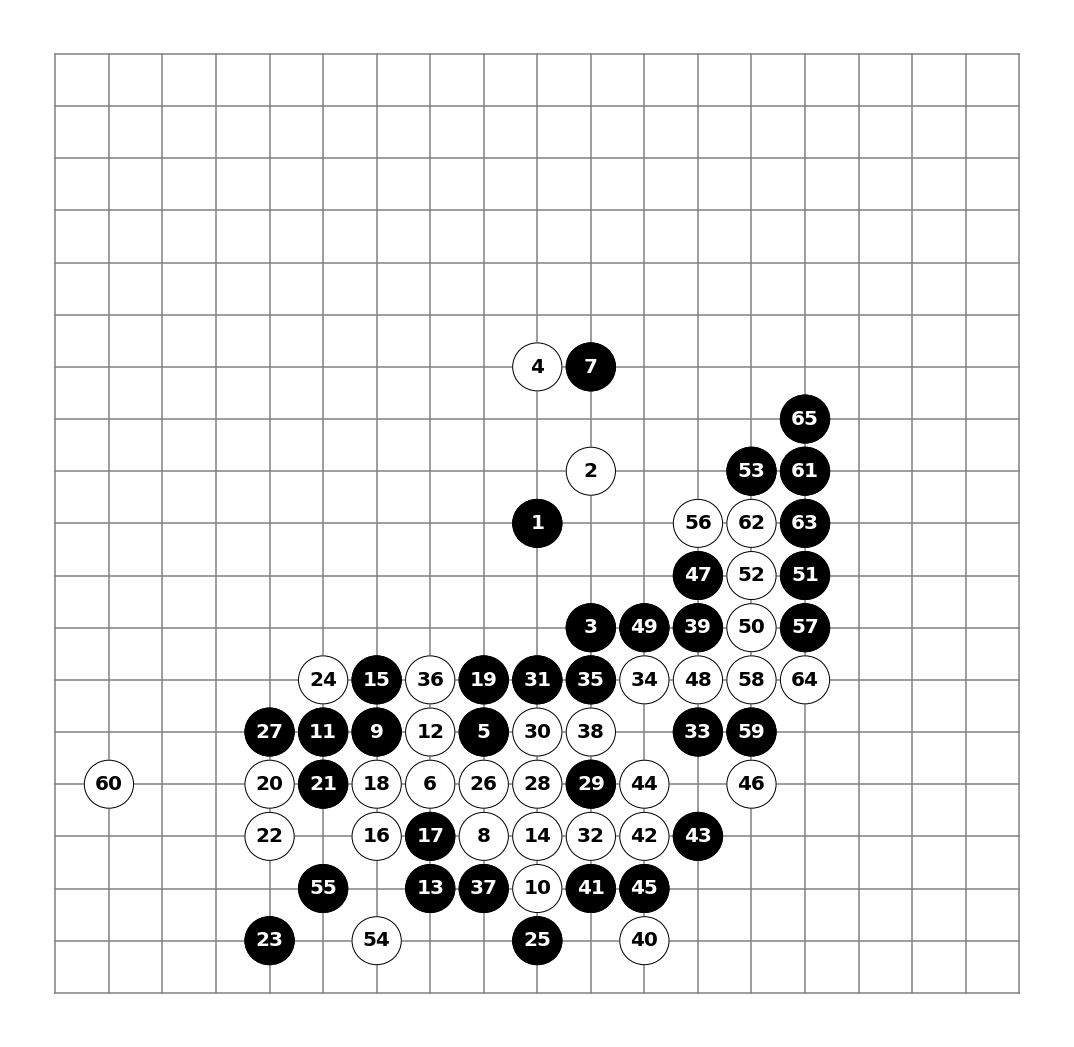

In [24]:
m = Mock5(19, 19)
m.play(agent_model(curr_pn), m5df.agent,
  print_intermediate_state=False)
m.plot()
plt.show()
plt.close()

위 기보가 상당히 극단적인 경우인데,
일단 운 좋게 정 가운데에 돌을 두는 것은 성공했습니다만,
(실제로는 정 가운데에 두는 경우가 별로 없습니다.)
이후에 3, 5, 7, 9수가 오목이 아니라 마치 바둑
행마에 가까울 정도로 띄엄띄엄 두는 것을 볼 수 있습니다.

이런 일이 일어나는 첫번째 이유는 우선 receptive field 크기에
한계가 있기 때문입니다. 현재는 kernel size 3 convolutional
layer를 8개 가량 쌓아서 한 점 기준으로 반경 8 내의 돌들을
확인하고 확률을 판단하는데,
이 경우 정 가운데에서 확인 가능한 범위는 고작 $17 \times 17$입니다.
때문에 처음에 판이 아예 빈 상황이라든가, 돌 주변에 다른 돌이 없는
경우에 그냥 제일 처음 비어있는 판과 구분하지 못하는 상황이 발생하는
것입니다.

다른 한가지 문제는 Softmax로 확률을 구하는 것과 관련되어 있는데,
예를 들어서 dimension 10 vector의 한 element만 1인 경우랑
dimension 20 vector 중 한 element만 1인 경우
softmax를 구하면 다음과 같이 차이가 납니다.

In [28]:
v1 = torch.zeros(10)
v1[0] = 1.0
print(nn.functional.softmax(v1, dim=-1))
v2 = torch.zeros(20)
v2[0] = 1.0
print(nn.functional.softmax(v2, dim=-1))

tensor([0.2320, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853, 0.0853,
        0.0853])
tensor([0.1252, 0.0460, 0.0460, 0.0460, 0.0460, 0.0460, 0.0460, 0.0460, 0.0460,
        0.0460, 0.0460, 0.0460, 0.0460, 0.0460, 0.0460, 0.0460, 0.0460, 0.0460,
        0.0460, 0.0460])


여기서 주목할 부분은 다른 원소의 값보다는 `[0]`의 확률입니다.
점수 자체는 그대로지만, 확률은 거의 반토막이 난 것을 볼 수
있습니다.
즉, 기존의 작은 판에서 거의 확정적으로 수를 두도록 학습이 되었더라도,
판 크기가 늘어나면 확률이 분산되어서 최선이 아닌 수를 둘 확률이
매우 올라가고, 이것이 실착으로 이어지는 것입니다.
이를 해결하려면 tempertured softmax에서 온도를 낮추도록
해야합니다.

In [30]:
v2 = torch.zeros(20)
v2[0] = 1.0
print(nn.functional.softmax(v2 / (0.5), dim=-1))

tensor([0.2800, 0.0379, 0.0379, 0.0379, 0.0379, 0.0379, 0.0379, 0.0379, 0.0379,
        0.0379, 0.0379, 0.0379, 0.0379, 0.0379, 0.0379, 0.0379, 0.0379, 0.0379,
        0.0379, 0.0379])


여기서는 간단히 square를 취해서 온도를
낮추는 것처럼 보정해보록 하겠습니다.

In [32]:
def pt_square(policy):
  def p(game):
    p = policy(game)
    return p * p
  p.name = 'pt_square({})'.format(policy.name)
  return p

def agent_model_sq(net):
  return agent(pt_regulate(pt_square(policy_model(net))))

In [34]:
a = [m5aa, m5ad, m5pt, m5df]
for i in range(len(a)):
    test_agents(19, 19, 20, agent_model_sq(curr_pn), a[i].agent)

-- Test Result --
* Agent1 = stochastic(pt_regulate(pt_square(model(7ff60118aa10)))) 
* Agent2 = agent-analysis-based
Total :    20
A1 Win:    18 (0.900) (avg.mov   23.4)
A2 Win:     2 (0.100) (avg.mov   38.0)
-- Test Result --
* Agent1 = stochastic(pt_regulate(pt_square(model(7ff60118aa10)))) 
* Agent2 = agent-analysis-defensive
Total :    20
A1 Win:    17 (0.850) (avg.mov   22.8)
A2 Win:     3 (0.150) (avg.mov   28.3)
-- Test Result --
* Agent1 = stochastic(pt_regulate(pt_square(model(7ff60118aa10)))) 
* Agent2 = agent-pt
Total :    20
A1 Win:    19 (0.950) (avg.mov   25.6)
A2 Win:     1 (0.050) (avg.mov  176.0)
-- Test Result --
* Agent1 = stochastic(pt_regulate(pt_square(model(7ff60118aa10)))) 
* Agent2 = agent-df
Total :    20
A1 Win:    20 (1.000) (avg.mov   28.2)
A2 Win:     0 (0.000) (avg.mov    0.0)


 [ Turn  23 ; 2P's turn (tone = X) ]
  | 0 1 2 3 4 5 6 7 8 9 A B C D E F G H I
--+--------------------------------------
0 | . . . . . . . . . . . . . . . . . . .
1 | . . . . . . . . . . . . . . . . . . .
2 | . . . . . . . . . . . . . . . . . . .
3 | . . . . . . . . . . . . . . . . . . .
4 | . . . . . . . . . . . . . . . . . . .
5 | . . . . . . . . . . . . . . . . . . .
6 | . . . . . . . . . . . . . . . . . . .
7 | . . . . . . . . . . . . . . . . . . .
8 | . . . . . . . . . . . . . . . . . . .
9 | . . . . . . . X X . . . . . . . . . .
A | . . . . . . X X O X . X . . . . . . .
B | . . . . . . X O O O . . . . . . . . .
C | . . . . . O . X O O O . . . . . . . .
D | . . . . . . . . O O X O . . . . . . .
E | . . . . . . X . X . . . O . . . . . .
F | . . . . . . . . . . . . . . . . . . .
G | . . . . . . . . . . . . . . . . . . .
H | . . . . . . . . . . . . . . . . . . .
I | . . . . . . . . . . . . . . . . . . .
1p (stochastic(pt_regulate(pt_square(model(7ff60118aa10))))) win!


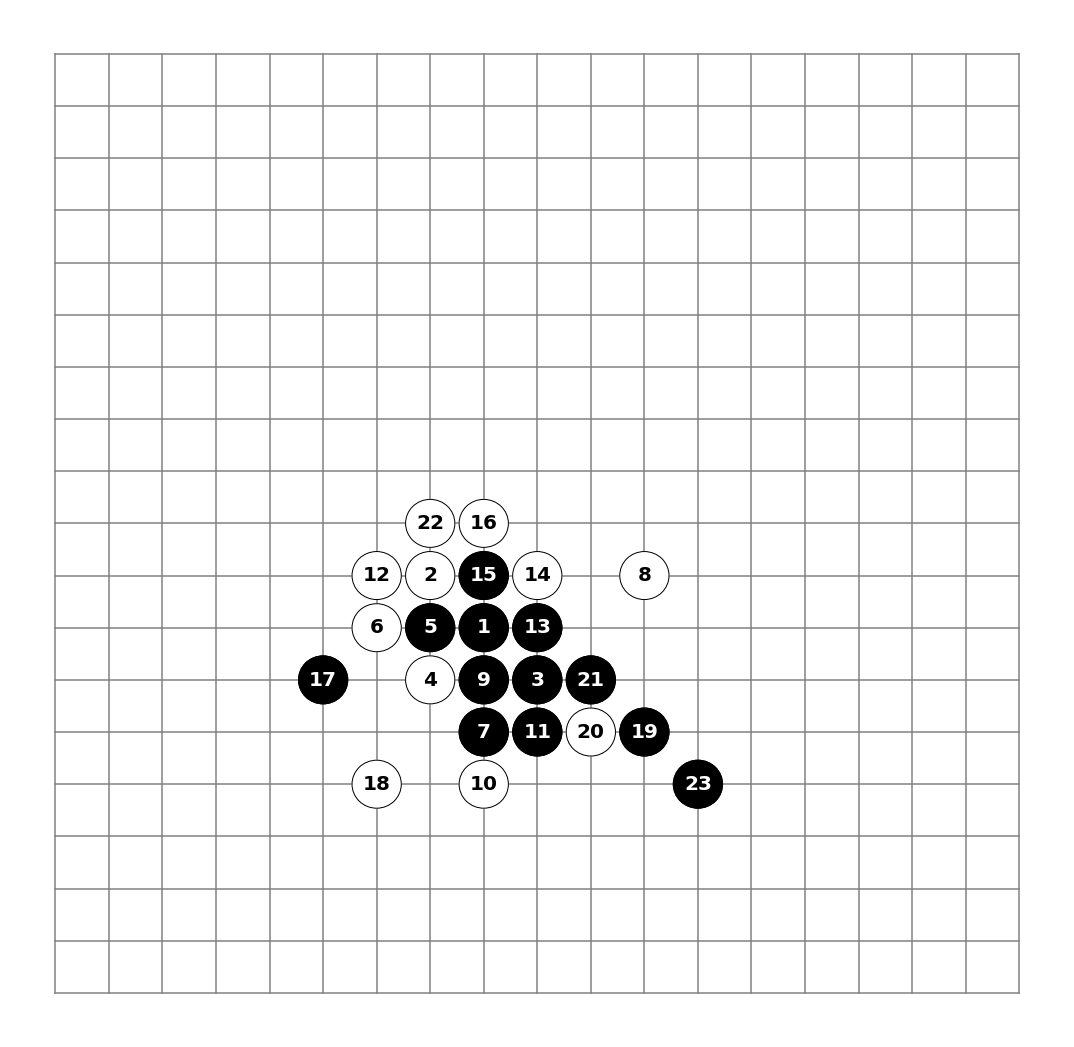

In [40]:
m = Mock5(19, 19)
m.play(agent_model_sq(curr_pn), m5df.agent,
  print_intermediate_state=False)
m.plot()
plt.show()
plt.close()

Square의 따른 차이를 비교하기 위해 square 한 것과 안 한 것을
대결시키면 다음과 같이 나옵니다.

In [42]:
test_agents(19, 19, 40, agent_model_sq(curr_pn), agent_model(curr_pn))

-- Test Result --
* Agent1 = stochastic(pt_regulate(pt_square(model(7ff60118aa10)))) 
* Agent2 = stochastic(pt_regulate(model(7ff60118aa10)))
Total :    40
A1 Win:    24 (0.600) (avg.mov   22.3)
A2 Win:    16 (0.400) (avg.mov   23.1)


0.6

 [ Turn  23 ; 2P's turn (tone = X) ]
  | 0 1 2 3 4 5 6 7 8 9 A B C D E F G H I
--+--------------------------------------
0 | . . . . . . . . . . . . . . . . . . .
1 | . . . . . . . . . . . . . . . . . . .
2 | . . . . . . . . . . . . . . . . . . .
3 | . . . . . . . . . . . . . . . . . . .
4 | . . . . . . . . . . . . . . . . . . .
5 | . . . . . . . . . . . . . . . . . . .
6 | . . . . . . X . . . . . . . . . . . .
7 | . . . . . X . O . O . . . . . . . . .
8 | . . . . . . . X O O O . . . . . . . .
9 | . . . . . . . . . O . . . O . . . . .
A | . . . . . . . X O O O . X . . . . . .
B | . . . . . . . X . O . X . . . . . . .
C | . . . . . . . . . X X X . . . . . . .
D | . . . . . . . . . X . . . . . . . . .
E | . . . . . . . . O . . . . . . . . . .
F | . . . . . . . . . . . . . . . . . . .
G | . . . . . . . . . . . . . . . . . . .
H | . . . . . . . . . . . . . . . . . . .
I | . . . . . . . . . . . . . . . . . . .
1p (stochastic(pt_regulate(pt_square(model(7ff60118aa10))))) win!


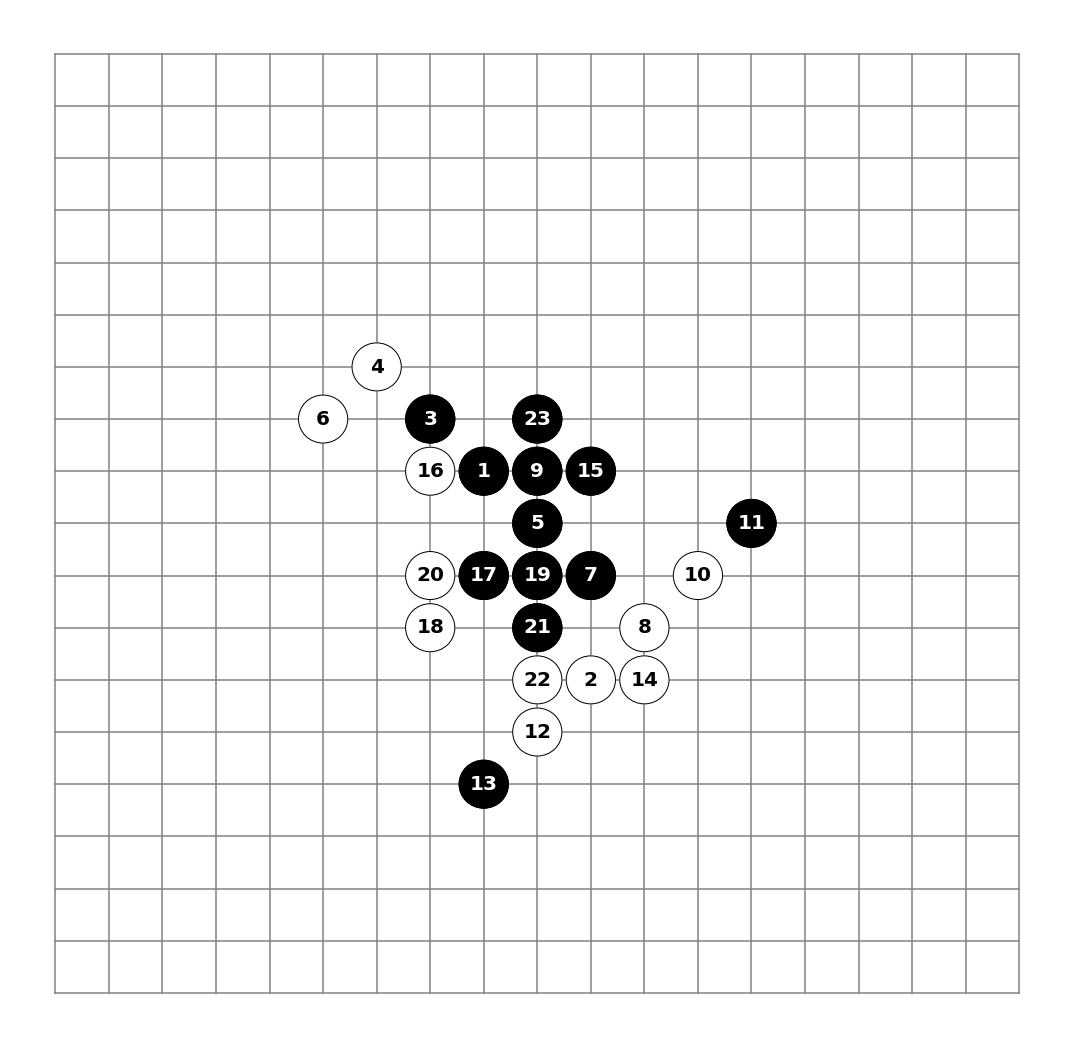

In [47]:
m = Mock5(19, 19)
m.play(agent_model_sq(curr_pn), agent_model(curr_pn),
  print_intermediate_state=False)
m.plot()
plt.show()
plt.close()

승률 자체가 높아지기는 합니다만, 압도적이지는 않습니다.
이는 온도가 높아지면 모험을 하게되고, 모험하는 수도 아주 나쁘지
않으면 유리하게 작용할 수도 있고,
아직 그에 대한 대응이 학습되지 않으면 그대로 말릴 수도 있기
때문입니다.